# Verification of updraft-downdraft coupling results

Thomas Schanzer  
January 2022

In this notebook, we check that the results in the main coupling notebook hold for other soundings and initial conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import pandas as pd
from scipy.interpolate import interp1d
import sys
import shelve

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator, DowndraftResult, equilibrate

In [89]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = ThermalGenerator(pressure, height, temperature, specific_humidity)

## Precipitation-driven downdrafts
### Overview plot

In [110]:
# updraft parameters
i_init_up = np.argmin(np.abs(pressure - 900*units.mbar))
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)/1.5
l_initial = 0*units.dimensionless
l_crit_all = [1e-3, 2e-3, 3e-3]*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
rate_all = [0.1, 0.25, 0.5]*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

rate_all, l_crit_all = np.meshgrid(rate_all, l_crit_all)
rate_all = rate_all.ravel()
l_crit_all = l_crit_all.ravel()

In [112]:
%%time
z_init_down_all = []
z_precip_top_all = []
updrafts_all = []
downdrafts_all = []
total_precip_all = []
for rate, l_crit in zip(rate_all, l_crit_all):
    sys.stdout.write(
        'epsilon = {:.2f}/km, l_crit = {:.1f} g/kg:\n'
        ''.format(rate.m, l_crit.m*1e3))
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        rate, dnu_db, drag, l_crit, basic=True)

    # downdraft parameters:
    # downdraft may initiate anywhere the updraft reaches that is
    # below 4 km and above 1 km
    i_init_down_min = np.min(
        np.argwhere(~np.isnan(updraft.velocity) & (height <= 4000*units.meter))
    )
    i_init_down_max = np.max(np.argwhere(height >= 1000*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 5)
    z_init_down = height[i_init_down_min:i_init_down_max+1:5]
    # the top of the precipitating layer must be somewhere the updraft
    # reaches and where there is nonzero precipitation
    i_precip_top_min = np.min(
        np.argwhere(~np.isnan(updraft.velocity) & (height <= 8000*units.meter))
    )
    i_precip_top_max = np.max(np.argwhere(updraft.precipitation > 0))
    i_precip_top = range(i_precip_top_min, i_precip_top_max+1, 5)
    z_precip_top = height[i_precip_top_min:i_precip_top_max+1:5]

    downdrafts = np.full(
        (len(i_init_down), len(i_precip_top)), np.nan, dtype='object')
    total_precip = np.full((len(i_init_down), len(i_precip_top)), np.nan)
    total_precip *= units.dimensionless

    valid_entries = np.atleast_2d(i_init_down).T >= np.atleast_2d(i_precip_top)
    i_valid = np.argwhere(valid_entries)[:,0]
    j_valid = np.argwhere(valid_entries)[:,1]
    n_calc = np.sum(valid_entries)
    n_done = 0
    for i, j in zip(i_valid, j_valid):
        n_done += 1
        sys.stdout.write(f'\r    Calculation {n_done} of {n_calc}    ')
        # sum the precipitation from the chosen levels, weighted
        # by the fractional mass remaining at each level since
        # the precipitation reported for the updraft is per unit mass
        # remaining, not per unit original mass
        total_precip[i,j] = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[j] : i_init_down[i] + 1])
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i,j], w_initial,
            rate, dnu_db, drag, basic=True)

    z_init_down_all.append(z_init_down)
    z_precip_top_all.append(z_precip_top)
    updrafts_all.append(updraft)
    downdrafts_all.append(downdrafts)
    total_precip_all.append(total_precip)
    sys.stdout.write('\n')
sys.stdout.write('\n')

epsilon = 0.10/km, l_crit = 1.0 g/kg:
    Calculation 170 of 170    
epsilon = 0.25/km, l_crit = 1.0 g/kg:
    Calculation 170 of 170    
epsilon = 0.50/km, l_crit = 1.0 g/kg:
    Calculation 137 of 137    
epsilon = 0.10/km, l_crit = 2.0 g/kg:
    Calculation 161 of 161    
epsilon = 0.25/km, l_crit = 2.0 g/kg:
    Calculation 161 of 161    
epsilon = 0.50/km, l_crit = 2.0 g/kg:
    Calculation 128 of 128    
epsilon = 0.10/km, l_crit = 3.0 g/kg:
    Calculation 155 of 155    
epsilon = 0.25/km, l_crit = 3.0 g/kg:
    Calculation 155 of 155    
epsilon = 0.50/km, l_crit = 3.0 g/kg:
    Calculation 111 of 111    

CPU times: user 2min 29s, sys: 699 ms, total: 2min 29s
Wall time: 2min 29s


1

In [113]:
max_velocity_all = []
max_velocity_height_all = []
min_height_all = []
for downdrafts in downdrafts_all:
    max_velocity = np.full(downdrafts.shape, np.nan)*units.meter/units.second
    max_velocity_height = np.full(downdrafts.shape, np.nan)*units.meter
    min_height = np.full(downdrafts.shape, np.nan)*units.meter
    for i in range(downdrafts.shape[0]):
        for j in range(downdrafts.shape[1]):
            if not isinstance(downdrafts[i,j], DowndraftResult):
                max_velocity[i,j] = np.nan
                max_velocity_height[i,j] = np.nan
                min_height[i,j] = np.nan
            else:
                max_velocity[i,j] = np.nanmin(downdrafts[i,j].velocity)
                i_max_velocity = np.nanargmin(downdrafts[i,j].velocity)
                max_velocity_height[i,j] = height[i_max_velocity]
                i_min_height = np.max(
                    np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
                min_height[i,j] = height[i_min_height]
    max_velocity_all.append(max_velocity)
    max_velocity_height_all.append(max_velocity_height)
    min_height_all.append(min_height)

In [114]:
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

z_max_precip = np.zeros(rate_all.size)*units.meter
for i, updraft in enumerate(updrafts_all):
    precip = updraft.precipitation*updraft.m_remaining
    precip[height > 4000*units.meter] = np.nan
    z_max_precip[i] = height[np.nanargmax(precip)]

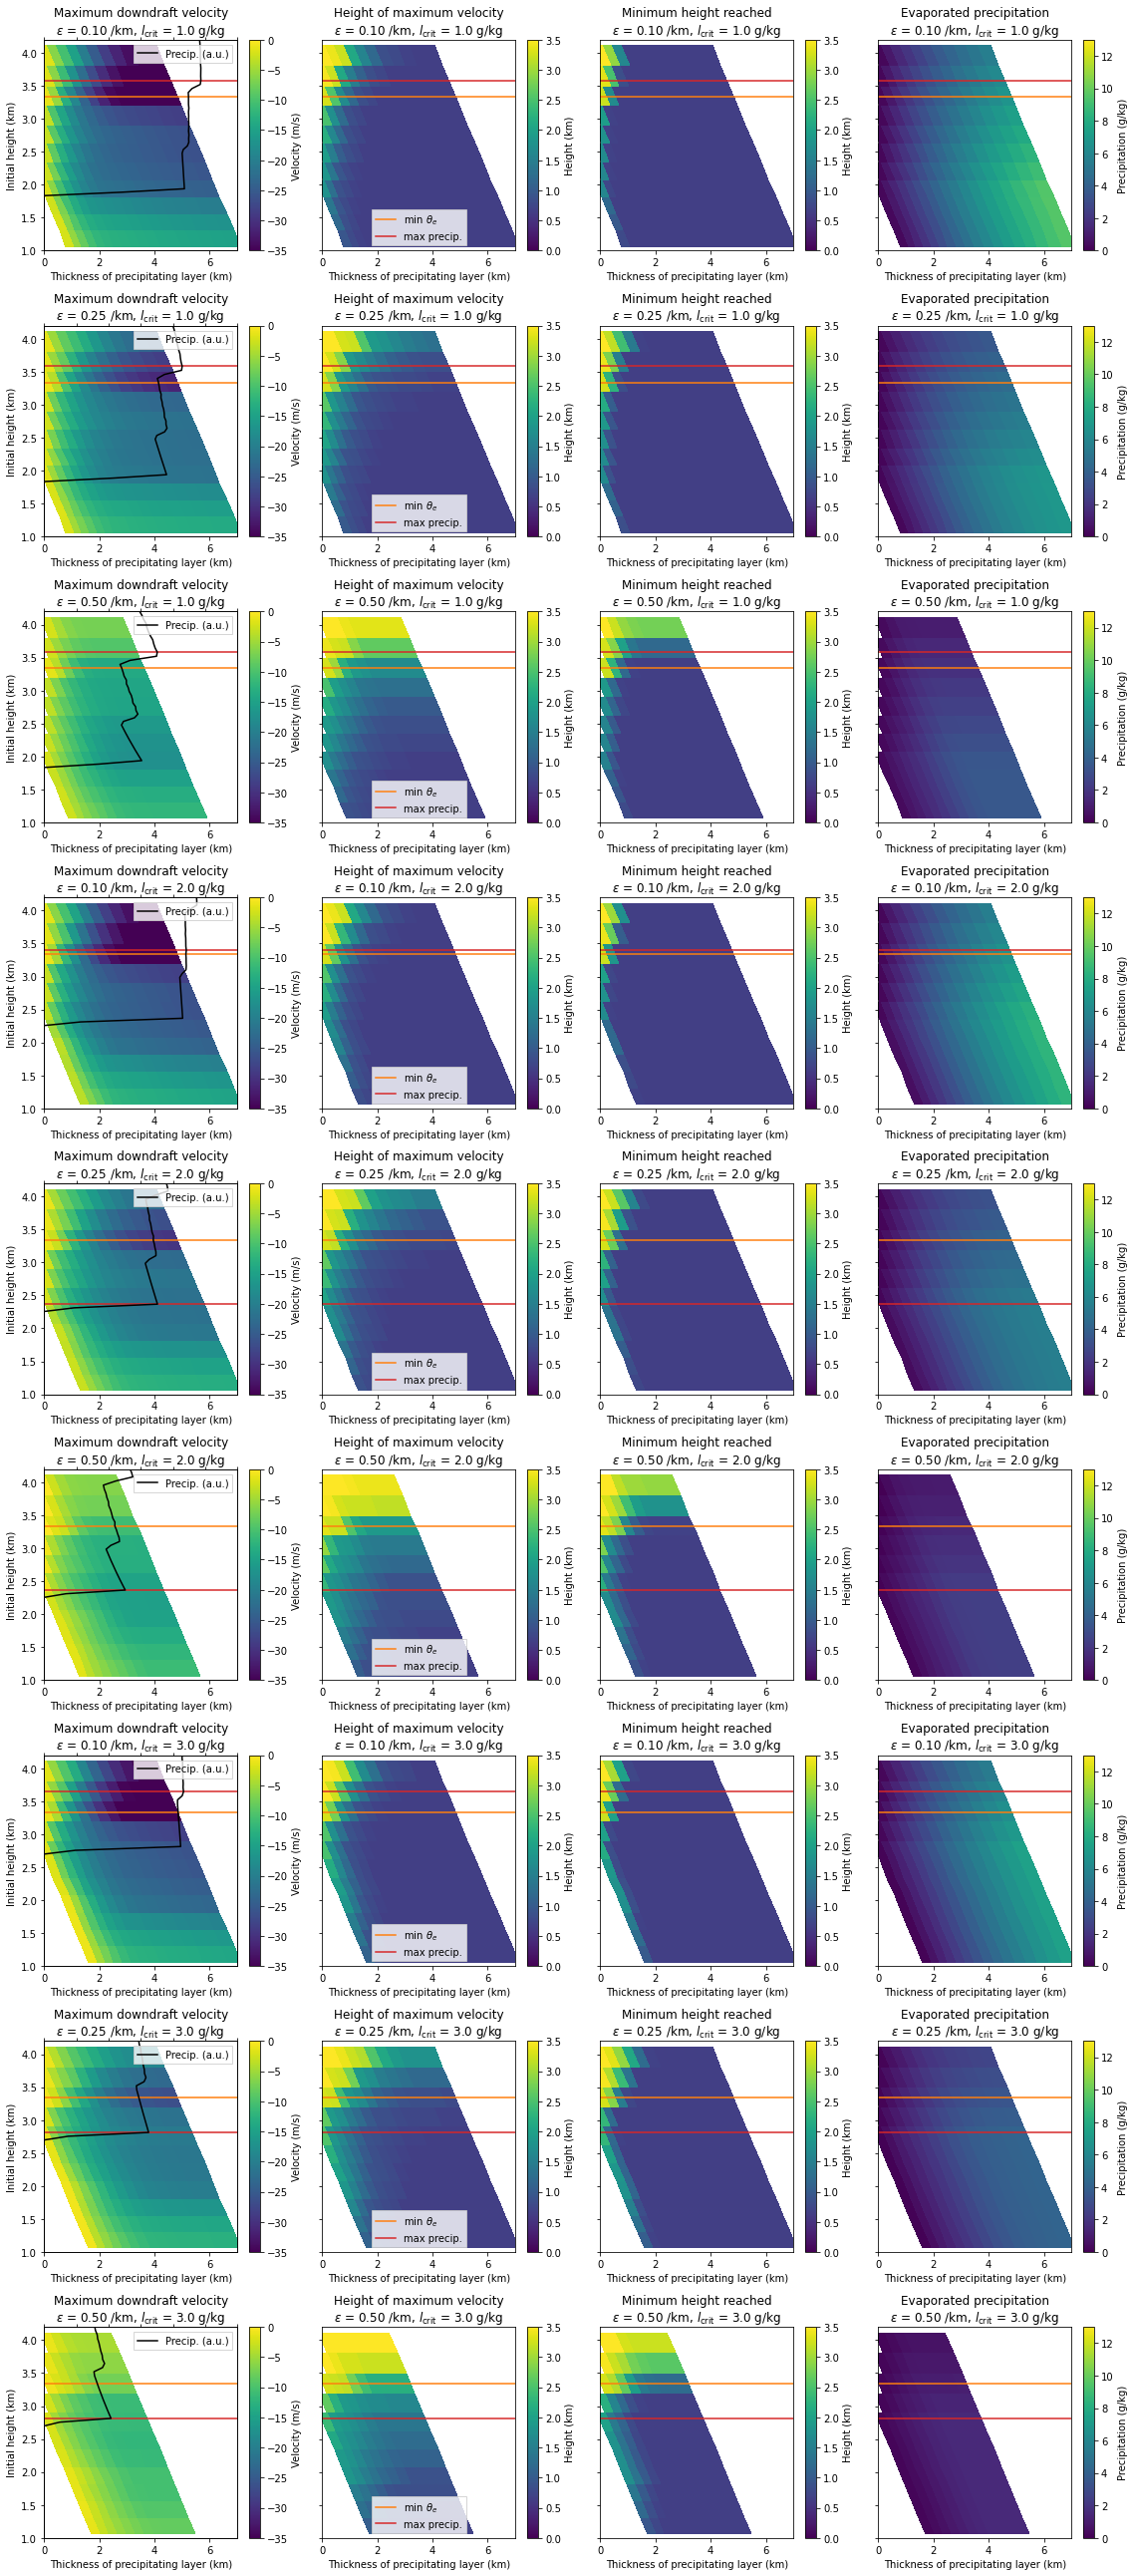

In [118]:
fig, axes = plt.subplots(rate_all.size, 4, figsize=(16,4*rate_all.size))
for i, (rate, l_crit) in enumerate(zip(rate_all, l_crit_all)):
    X, Y = np.meshgrid(z_precip_top_all[i], z_init_down_all[i])
    
    mesh = axes[i,0].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, max_velocity_all[i], shading='nearest')
    mesh.set_clim(-35, 0)
    cbar = fig.colorbar(mesh, ax=axes[i,0])
    cbar.set_label('Velocity (m/s)')
    axes[i,0].set(xlabel='Thickness of precipitating layer (km)',
                ylabel='Initial height (km)',
                title='Maximum downdraft velocity\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,0].axhline(z_min_theta_e*1e-3, color='tab:orange')
    axes[i,0].axhline(z_max_precip[i]*1e-3, color='tab:red')
    axes[i,0].set_xlim(0, 7)
    axes[i,0].set_ylim(1, 4.2)
    ax = axes[i,0].twiny()
    ax.plot(updrafts_all[i].precipitation*updrafts_all[i].m_remaining*1e3,
            height*1e-3, 'k', label='Precip. (a.u.)')
    ax.set_xlim(0, 0.15)
    ax.set(xlabel='')
    ax.set_xticklabels([])
    ax.legend(loc='upper right', fancybox=False)
    
    mesh = axes[i,1].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, max_velocity_height_all[i]*1e-3,
        shading='nearest')
    mesh.set_clim(0, 3.5)
    cbar = fig.colorbar(mesh, ax=axes[i,1])
    cbar.set_label('Height (km)')
    axes[i,1].set(xlabel='Thickness of precipitating layer (km)',
                ylabel='',
                title='Height of maximum velocity\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,1].set_yticklabels([])
    axes[i,1].axhline(z_min_theta_e*1e-3, color='tab:orange',
                      label=r'min $\theta_e$')
    axes[i,1].axhline(z_max_precip[i]*1e-3, color='tab:red',
                      label='max precip.')
    axes[i,1].set_xlim(0, 7)
    axes[i,1].set_ylim(1, 4.2)
    axes[i,1].legend(loc='lower center', fancybox=False)
    
    mesh = axes[i,2].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, min_height_all[i]*1e-3, shading='nearest')
    mesh.set_clim(0, 3.5)
    cbar = fig.colorbar(mesh, ax=axes[i,2])
    cbar.set_label('Height (km)')
    axes[i,2].set(xlabel='Thickness of precipitating layer (km)',
                  ylabel='',
                  title='Minimum height reached\n'
                        '$\epsilon$ = {:.2f} /km, '
                        '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                        ''.format(rate.m, l_crit.m*1e3))
    axes[i,2].set_yticklabels([])
    axes[i,2].axhline(z_min_theta_e*1e-3, color='tab:orange')
    axes[i,2].axhline(z_max_precip[i]*1e-3, color='tab:red')
    axes[i,2].set_xlim(0, 7)
    axes[i,2].set_ylim(1, 4.2)
    
    mesh = axes[i,3].pcolormesh(
        (X - Y)*1e-3, Y*1e-3, total_precip_all[i]*1e3, shading='nearest')
    mesh.set_clim(0, 13)
    cbar = fig.colorbar(mesh, ax=axes[i,3])
    cbar.set_label('Precipitation (g/kg)')
    axes[i,3].set(xlabel='Thickness of precipitating layer (km)',
                ylabel='',
                title='Evaporated precipitation\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,3].set_yticklabels([])
    axes[i,3].axhline(z_min_theta_e*1e-3, color='tab:orange')
    axes[i,3].axhline(z_max_precip[i]*1e-3, color='tab:red')
    axes[i,3].set_xlim(0, 7)
    axes[i,3].set_ylim(1, 4.2)
    

fig.tight_layout()

### Detailed analysis

In [120]:
# updraft parameters
i_init_up = np.argmin(np.abs(pressure - 900*units.mbar))
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)/1.5
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 1000*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [121]:
%%time
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts = np.zeros((z_init_down.size, epsilon.size), dtype='object')
total_precip = np.zeros((z_init_down.size, epsilon.size))*units.dimensionless
n_calc = epsilon.size*z_init_down.size
n_done = 0
for j in range(epsilon.size):
    updrafts[j] = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon[j], dnu_db, drag, l_crit, basic=True)
    
    for i in range(z_init_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        
        total_precip[i,j] = np.nansum((
            updrafts[j].precipitation*updrafts[j].m_remaining
        )[i_precip_top[i] : i_init_down[i] + 1])
        
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i,j], w_initial,
            epsilon[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1512 of 1512    
CPU times: user 3min 20s, sys: 1.08 s, total: 3min 21s
Wall time: 3min 21s


1

In [122]:
max_velocity = np.zeros((z_init_down.size, epsilon.size))
max_velocity *= units.meter/units.second
max_velocity_height = np.zeros((z_init_down.size, epsilon.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon.size))*units.meter
max_velocity_up = np.zeros(epsilon.size)*units.meter/units.second
max_precip_height = np.zeros(epsilon.size)*units.meter

for j in range(epsilon.size):
    max_velocity_up[j] = np.nanmax(updrafts[j].velocity)
    i_max_precip = np.nanargmax(
        updrafts[j].precipitation*updrafts[j].m_remaining)
    max_precip_height[j] = height[i_max_precip]
    for i in range(z_init_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
precip_profile = concatenate(
    [[updraft.precipitation] for updraft in updrafts]).T
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
            
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

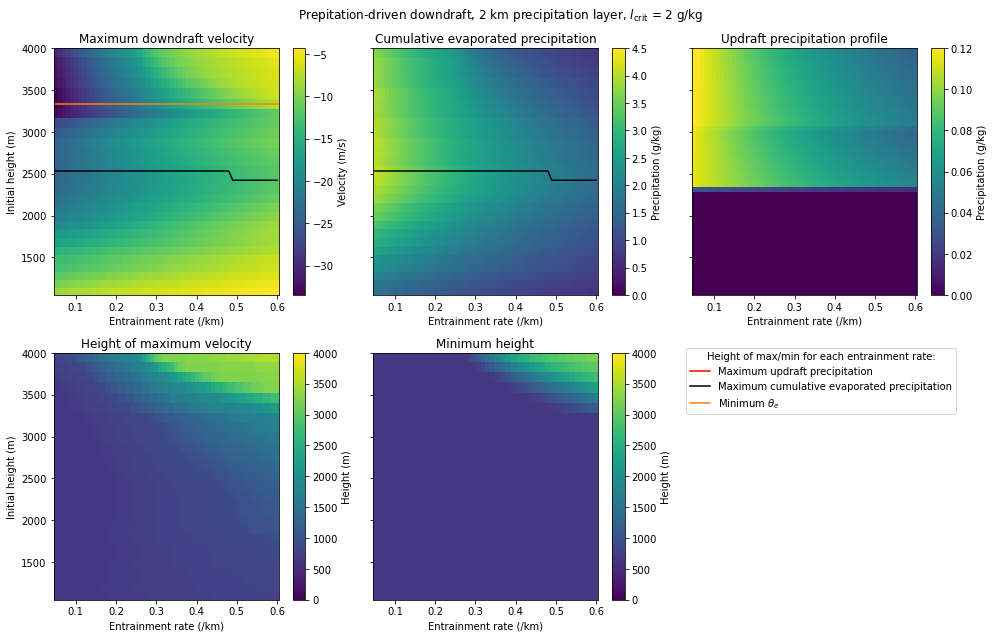

In [125]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon, z_init_down, max_velocity, shading='nearest')
# mesh.set_clim(-23, -2)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].plot(epsilon, max_precip_height, 'r',
               label='Maximum updraft precipitation')
axes[0,0].plot(epsilon, max_evap_height, 'k',
               label='Maximum cumulative evaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Entrainment rate (/km)', ylabel='Initial height (m)',
       title='Maximum downdraft velocity')
axes[0,0].set_ylim(1050, 4000)

mesh = axes[0,1].pcolormesh(
    epsilon, z_init_down, total_precip*1e3, shading='nearest')
mesh.set_clim(0, 4.5)
cbar = plt.colorbar(mesh, ax=axes[0,1])
cbar.set_label('Precipitation (g/kg)')
axes[0,1].plot(epsilon, max_evap_height, 'k', label='Max evap.')
axes[0,1].set(xlabel='Entrainment rate (/km)', ylabel='',
       title='Cumulative evaporated precipitation')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(1050, 4000)

mesh = axes[0,2].pcolormesh(
    epsilon, height, precip_profile*1e3, shading='nearest')
mesh.set_clim(0, 0.12)
cbar = plt.colorbar(mesh, ax=axes[0,2])
cbar.set_label('Precipitation (g/kg)')
axes[0,2].plot(epsilon, max_precip_height, 'r', label='Max precip.')
axes[0,2].set(xlabel='Entrainment rate (/km)', ylabel='',
       title='Updraft precipitation profile')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(1050, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 4000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Entrainment rate (/km)', ylabel='Initial height (m)',
       title='Height of maximum velocity')
axes[1,0].set_ylim(1050, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 4000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Entrainment rate (/km)', ylabel='',
       title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(1050, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.69, 0.35),
           title='Height of max/min for each entrainment rate:')

fig.suptitle('Prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg')
fig.tight_layout()

In [127]:
def overshooting_pair(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit):
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon, dnu_db, drag, l_crit, basic=True)
    i_top = np.min(np.argwhere(~np.isnan(updraft.velocity)))
    t_init_down, q_init_down, l_init_down = equilibrate(
        pressure[i_top], updraft.temperature[i_top],
        updraft.specific_humidity[i_top], updraft.liquid_content[i_top])
    downdraft = generator.downdraft(
        i_top, t_init_down, q_init_down, l_init_down, w_initial,
        epsilon, dnu_db, drag, basic=True)
    return updraft, downdraft

In [128]:
# updraft parameters
i_init_up_max = height.size - 1
i_init_up_min = np.argmin(np.abs(height - 1e4*units.meter))
i_init_up = range(i_init_up_min, i_init_up_max+1, 4)
z_init_up = height[i_init_up_min:i_init_up_max+1:4]
t_pert = 1.0*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.02)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [129]:
%%time
updrafts = np.zeros((z_init_up.size, epsilon.size), dtype='object')
downdrafts = np.zeros((z_init_up.size, epsilon.size), dtype='object')
n_calc = z_init_up.size*epsilon.size
n_done = 0
for i in range(z_init_up.size):
    for j in range(epsilon.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        updrafts[i,j], downdrafts[i,j] = overshooting_pair(
            i_init_up[i], t_pert, q_pert, l_initial, w_initial,
            epsilon[j], dnu_db, drag, l_crit)
sys.stdout.write('\n')

Calculation 1584 of 1584    
CPU times: user 10min 5s, sys: 2.25 s, total: 10min 8s
Wall time: 10min 8s


1

In [130]:
max_velocity_up = np.zeros((z_init_up.size, epsilon.size))
max_velocity_up *= units.meter/units.second
max_velocity_down = np.zeros((z_init_up.size, epsilon.size))
max_velocity_down *= units.meter/units.second
z_top = np.zeros((z_init_up.size, epsilon.size))*units.meter
z_min_down = np.zeros((z_init_up.size, epsilon.size))*units.meter
for i in range(z_init_up.size):
    for j in range(epsilon.size):
        max_velocity_up[i,j] = np.nanmax(updrafts[i,j].velocity)
        max_velocity_down[i,j] = np.nanmin(downdrafts[i,j].velocity)
        i_top = np.min(np.argwhere(~np.isnan(updrafts[i,j].velocity)))
        z_top[i,j] = height[i_top]
        i_min_down = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        z_min_down[i,j] = height[i_min_down]

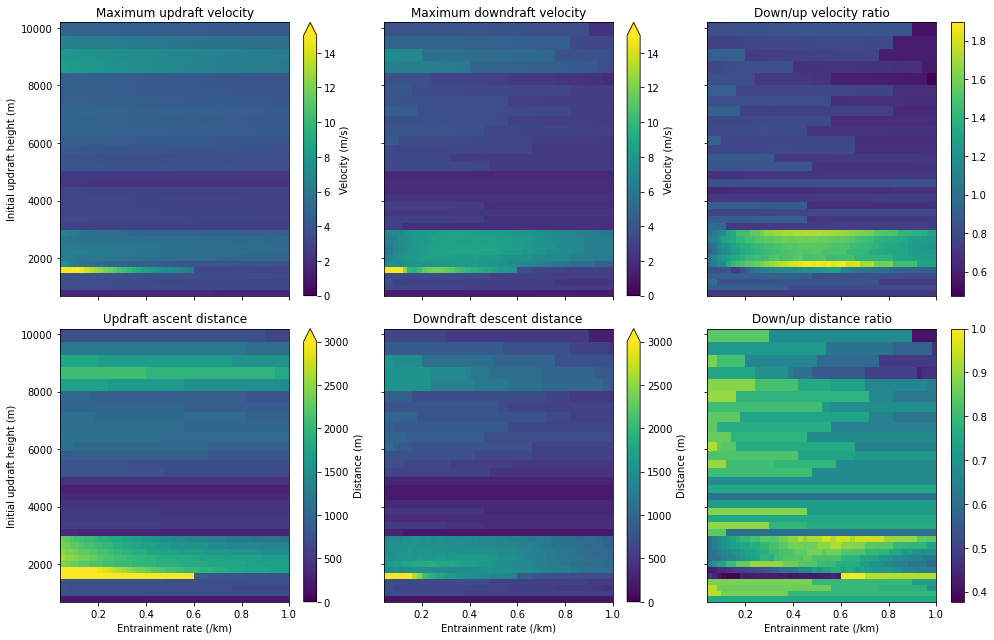

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

mesh = axes[0,0].pcolormesh(
    epsilon, z_init_up, max_velocity_up, shading='nearest')
mesh.set_clim(0, 15)
cbar = plt.colorbar(mesh, ax=axes[0,0], extend='max')
cbar.set_label('Velocity (m/s)')
axes[0,0].set_title('Maximum updraft velocity')

mesh = axes[0,1].pcolormesh(
    epsilon, z_init_up, -max_velocity_down, shading='nearest')
mesh.set_clim(0, 15)
cbar = plt.colorbar(mesh, ax=axes[0,1], extend='max')
cbar.set_label('Velocity (m/s)')
axes[0,1].set_title('Maximum downdraft velocity')

mesh = axes[0,2].pcolormesh(
    epsilon, z_init_up, -max_velocity_down/max_velocity_up, shading='nearest')
cbar = plt.colorbar(mesh, ax=axes[0,2])
axes[0,2].set_title('Down/up velocity ratio')

mesh = axes[1,0].pcolormesh(
    epsilon, z_init_up, z_top - np.atleast_2d(z_init_up).T, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0], extend='max')
cbar.set_label('Distance (m)')
axes[1,0].set_title('Updraft ascent distance')

mesh = axes[1,1].pcolormesh(
    epsilon, z_init_up, z_top - z_min_down, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1], extend='max')
cbar.set_label('Distance (m)')
axes[1,1].set_title('Downdraft descent distance')

mesh = axes[1,2].pcolormesh(
    epsilon, z_init_up,
    (z_top - z_min_down)/(z_top - np.atleast_2d(z_init_up).T),
    shading='nearest')
cbar = plt.colorbar(mesh, ax=axes[1,2])
axes[1,2].set_title('Down/up distance ratio')

for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[0,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
for ax in axes[:,0].ravel():
    ax.set_ylabel('Initial updraft height (m)')
    
for ax in axes[1,:].ravel():
    ax.set_xlabel('Entrainment rate (/km)')

fig.tight_layout()